# Negative Binomial Distribution

The negative binomial likelihood, typically looks like:

$$
NB(y_n | r, p) = {y_n + r - 1 \choose y_n}p^r (1-p)^{y_n}
$$

Intuitively, this is describing the likelihood of n successes given a system where you draw until n failures. It is parameterized by a probability of failure p, and a number of failures r, which enables it to be more expressive (in terms of variance) compared to typical binomial or poisson distributions. 

We typically want to assemble negative binomial models in some type of log-linear form. The logit transformation:

$$
\eta_n = \log (\frac{1-p_n}{p_n})
$$

implies we can recover p as 

$$
p = \frac{1}{1+e^{\eta_n}}
$$

and $(1-p)$ as:

$$
(1-p) = \frac{e^{\eta_n}}{1 + e^{\eta_n}}
$$


When we drop the binomial term, which doesn't rely on the probability of failure p, we get:

$$
NB(y_n | r, p) \propto p^r (1-p)^{y_n}
$$

substitution gives:

$$
NB(y_n | r, \eta_n) \propto (\frac{1}{1+e^{\eta_n}})^r (\frac{e^{\eta_n}}{1 + e^{\eta_n}})^{y_n}
$$

Which we simplify to:

$$
NB(y_n | r, \eta_n) \propto (\frac{1}{1+e^{\eta_n}})^r (\frac{e^{\eta_n}}{1 + e^{\eta_n}})^{y_n}
$$

or

$$
NB(y_n | r, \eta_n) \propto \frac{e^{\eta_n y_n}}{(1+e^\eta_n)^{y_n + r}}
$$



# The trouble with this form.

In order to do the Bayes thing, where we take a prior, and update based on the data we have:

$$
p(\theta | D) = \frac{p(D | \theta)p(\theta)}{p(D)}
$$

We would like to have a form where the posterior that we draw is in the same distribution as the prior distribution. PSW showed that you could do this via the following system:

$$
(\omega | \beta) \sim \text{PG}(n_i, x_i^T \beta)
$$

$$
(\beta | y, \omega) \sim \text{N}(m_\omega, V_\omega)
$$

Where the covariance
$$
V_\omega = (X^T \Omega X + B^{-1})^{-1}
$$

and the mean
$$
m_\omega = V_\omega(X^T \kappa + B^{-1}b)^{-1}
$$

are captured.


In [57]:
class PolyaGammaSampler:

    def __init__(self):
        pass
    
    def sample_scalar(self, b, c, truncation=200):
        total = 0.0
        for k in range(1, truncation + 1):
            term_1 = np.random.gamma(b, 1.0)
            term_2 = (k - 0.5)**2
            term_3 = (c / (2 * np.pi))**2
            total += term_1 / (term_2 + term_3)
        
        return 0.5 * total / (np.pi**2)

    def sample(self, b_array, c_array, truncation=200):
        b_array = np.asarray(b_array)
        c_array = np.asarray(c_array)
        N = b_array.shape[0]
        omega = np.zeros(N)
        
        for n in range(N):
            omega[n] = self.sample_scalar(b_array[n], c_array[n], truncation=truncation)
        
        return omega

pg = PolyaGammaSampler()

# Data 

Here, we setup a linear regression task for negative binomial distributed data. We have an intercept of (0.5) and two variables of (1.0, -1.5). The main goal of this task is to try to infer the coefficients.

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.special import gammaln
from tqdm import trange

# 1. Generate data
N = 200
X = np.hstack([np.ones((N, 1)), np.random.randn(N, 2)])
# coefficients, first is the intercept
beta_true = np.array([0.5, 1.0, -1.5])
r_true = 10.0

eta = X @ beta_true
mu = np.exp(eta)
p = r_true / (r_true + mu)
y = nbinom.rvs(r_true, p)

We can construct a very simple linear regression type system, that allows us to capture these differences. If we wanted we could also include some kind of system to capture size factors, but for right now lets ignore that.

In [59]:
class NegativeBinomialRegression:

    def __init__(self, X, y):
        # Design matrix and response (as a count variable)
        self.X = X
        self.y = y

        # Prior distribution for our parameters.
        self.prior_mean = np.zeros(self.X.shape[1])
        self.prior_precision = np.array([0.01] * self.X.shape[1])

        # Beta Coefficient that we learn.
        self.beta = np.zeros(self.X.shape[1])

        # We will update our dispersion parameter using simple proposals.
        self.dispersion = 5.0

        # Proposal sigma for dispersion parameter
        proposal_sigma = 1.0

        self.polya_gamma_sampler = PolyaGammaSampler()

        self.beta_history = []
        self.dispersion_history = []

    def update_coefficients(self):
        # eta = X_0 + X_1 * beta + ...
        eta = self.X @ self.beta
        
        # PG(b, c); b = y + r (successes + failures), c = linear gaussian formula (ie eta)
        omega = self.polya_gamma_sampler.sample(
            self.y + self.dispersion, 
            eta, 
            truncation=100
        )

        # Calculate our mean and covariance for the posterior distribution
        # posterior covariance = ((data precision) + (prior precision))^-1
        posterior_covariance = np.linalg.inv(
            (self.X.T @ np.diag(omega) @ self.X) + np.diag(self.prior_precision)
        )

        # Posterior mean is (uncertainty in parameters) @ (weighted sum of residuals) + prior contribution
        # which is also more simply: posterior covariance @ (update gradient)
        # 
        # Posterior covariance tells us how much certainty we have in our variables
        # which informs the strength of update. Its adjusting the inner product space  
        # so that we decide how far we're going to step beforehand, using the gradient, 
        # but we change the landscape of where we're stepping based on the covariance.
        #
        # low variance = small steps, large variance = large steps
        # when we arrive at a location of some certainty, we should not diverge from that location 
        posterior_mean = posterior_covariance @ (self.X.T @ (self.y - self.dispersion) / 2) + self.prior_precision @ self.prior_mean

        beta = np.random.multivariate_normal(posterior_mean, posterior_covariance)
        self.beta_history.append(beta)
        self.beta = beta
        
    def update_dispersion(self, proposal_standard_deviation = 1.0):
        eta = self.X @ self.beta
        log_r_old = self.log_posterior_r(self.dispersion, self.y, eta)
        r_prop = np.abs(self.dispersion + np.random.normal(0, proposal_standard_deviation))  # reflect to keep r > 0
        log_r_prop = self.log_posterior_r(r_prop, self.y, eta)
        
        alpha = np.exp(log_r_prop - log_r_old)
        if np.random.rand() < alpha:
            self.dispersion = r_prop  # accept
        
        # Save
        self.dispersion_history.append(r)

    @staticmethod
    def log_posterior_r(r, y, eta, a0=2.0, b0=0.1):
        mu = np.exp(eta)
        p = r / (r + mu)
        ll = np.sum(gammaln(y + r) - gammaln(r) + r * np.log(p) + y * np.log(1 - p))
        prior = (a0 - 1) * np.log(r) - b0 * r
        return ll + prior

In [73]:
from tqdm import trange
nbr = NegativeBinomialRegression(X, y)

for i in trange(500):
    nbr.update_coefficients()
    nbr.update_dispersion()

100%|██████████| 500/500 [00:05<00:00, 88.33it/s]


In [74]:
print("Beta_true = ", beta_true)
print("Beta_learned = ", nbr.beta)


Beta_true =  [ 0.5  1.  -1.5]
Beta_learned =  [-0.57382773  1.00282251 -1.57351007]


Ignoring the first term, which is our intercept term, the system has learned really well! Lets see how the posterior samples look

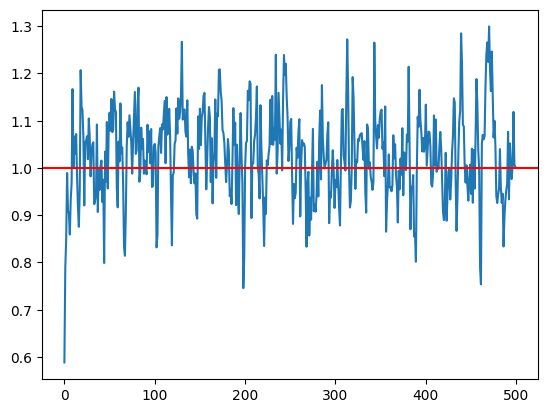

In [75]:
plt.plot([x[1] for x in nbr.beta_history])
plt.axhline(1.0, c="red")

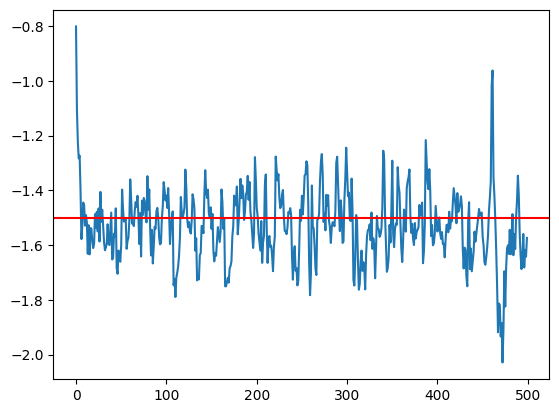

In [76]:
plt.plot([x[2] for x in nbr.beta_history])
plt.axhline(-1.5, c="red")

Good, so we created a sampler that learns a thing. Now we can start asking more difficult questions...